## Model Training

In [211]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#### Import dataset

In [174]:
df = pd.read_csv('data/stud.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [175]:
df.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

#### X & y in dataframe

In [176]:
X = df.drop('math_score',axis=1)
y = df['math_score']
print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (1000, 7)
Shape of y is (1000,)


#### Ordinal Encoding in parental education

In [177]:
X['parental_level_of_education'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [178]:
order_label = {'some high school':1, 
               'high school':2,
              'some college':3,
               "associate's degree":4,
               "bachelor's degree":5,
               "master's degree":6
              }
X['parental_level_of_education'] = X['parental_level_of_education'].map(order_label)

In [179]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,5,standard,none,72,74
1,female,group C,3,standard,completed,90,88
2,female,group B,6,standard,none,95,93
3,male,group A,4,free/reduced,none,57,44
4,male,group C,3,standard,none,78,75


#### Numerical and categorical variables in X

In [180]:
num_var = X.select_dtypes(exclude='O').columns.tolist()
num_var

['parental_level_of_education', 'reading_score', 'writing_score']

In [181]:
num_var.remove('parental_level_of_education')
num_var

['reading_score', 'writing_score']

In [182]:
cat_var = X.select_dtypes(include='O').columns.tolist() 
cat_var

['gender', 'race_ethnicity', 'lunch', 'test_preparation_course']

#### One-Hot Encoding & Standard Scaling

In [183]:
oneHotEnc = OneHotEncoder(sparse_output=False, drop='first')
scale = StandardScaler()

pipeline = ColumnTransformer(
    [
        ("OneHotEncoder",oneHotEnc,cat_var),
        ("StandardScaler",scale,num_var)
    ]
)

In [184]:
X_trans = pipeline.fit_transform(X)

In [185]:
X_trans.shape

(1000, 9)

#### Getting mean & std for pipeline

In [200]:
pipeline.named_transformers_["StandardScaler"].mean_

array([69.169, 68.054])

In [201]:
pipeline.named_transformers_["StandardScaler"].scale_

array([14.59289002, 15.18805728])

#### Back to df

In [186]:
cat_var_trans = pipeline.named_transformers_['OneHotEncoder'].get_feature_names_out(cat_var)

In [187]:
cat_var_trans

array(['gender_male', 'race_ethnicity_group B', 'race_ethnicity_group C',
       'race_ethnicity_group D', 'race_ethnicity_group E',
       'lunch_standard', 'test_preparation_course_none'], dtype=object)

In [188]:
cat_var_trans = list(cat_var_trans)

In [189]:
features = cat_var_trans + num_var
features

['gender_male',
 'race_ethnicity_group B',
 'race_ethnicity_group C',
 'race_ethnicity_group D',
 'race_ethnicity_group E',
 'lunch_standard',
 'test_preparation_course_none',
 'reading_score',
 'writing_score']

In [190]:
X_trans = pd.DataFrame(X_trans,columns=features)
X_trans['parental_level_of_education'] = X['parental_level_of_education']
X_trans.shape

(1000, 10)

In [191]:
X_trans.head()

,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,lunch_standard,test_preparation_course_none,reading_score,writing_score,parental_level_of_education
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.193999,0.391492,5
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.427476,1.313269,3
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.770109,1.642475,6
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.833899,-1.583744,4
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.605158,0.457333,3


The dataset is ready to be trained.

#### Train test split

In [193]:
print(f'{X_trans.shape} & {y.shape}')

(1000, 10) & (1000,)


In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_trans,y,test_size=0.3,random_state=42)

In [195]:
print(f'Shape for X_train is {X_train.shape}')
print(f'Shape for X_test is {X_test.shape}')
print(f'Shape for y_train is {y_train.shape}')
print(f'Shape for y_test is {y_test.shape}')

Shape for X_train is (700, 10)
Shape for X_test is (300, 10)
Shape for y_train is (700,)
Shape for y_test is (300,)


In [203]:
X_train.head()

,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,lunch_standard,test_preparation_course_none,reading_score,writing_score,parental_level_of_education
541,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.879264,0.786539,4
440,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.810737,0.720698,3
482,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.080108,-0.464444,3
422,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.765373,-0.069397,6
778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.673684,0.918221,3


In [204]:
X_test.head()

,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,lunch_standard,test_preparation_course_none,reading_score,writing_score,parental_level_of_education
521,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.153370,1.049904,4
737,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.217161,0.325651,3
740,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.262525,0.259809,5
660,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.536631,0.325651,3
411,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.947790,0.654857,3


In [205]:
y_train

541    79
440    67
482    68
422    47
778    72
       ..
106    87
270    69
860    53
435    50
102    85
Name: math_score, Length: 700, dtype: int64

In [206]:
y_test

521    91
737    53
740    80
660    74
411    84
       ..
468    77
935    70
428    65
7      40
155    70
Name: math_score, Length: 300, dtype: int64

In [207]:
X_train['gender_male'].value_counts()

gender_male
0.0    375
1.0    325
Name: count, dtype: int64

In [208]:
X_test['gender_male'].value_counts()

gender_male
1.0    157
0.0    143
Name: count, dtype: int64

In [216]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train,y_train)

LinearRegression()

In [241]:
y_pred = linear_regressor.predict(X_test)
score_lr = linear_regressor.score(X_test,y_test)*100
score_lr

87.6466178837196

In [227]:
linear_regressor_df = pd.DataFrame({'y_pred':y_pred,'y_test':y_test})
linear_regressor_df

,y_pred,y_test
521,76.534060,91
737,58.262679,53
740,77.173380,80
660,76.397475,74
411,87.016434,84
...,...,...
468,72.711050,77
935,61.985372,70
428,59.117534,65
7,44.238672,40


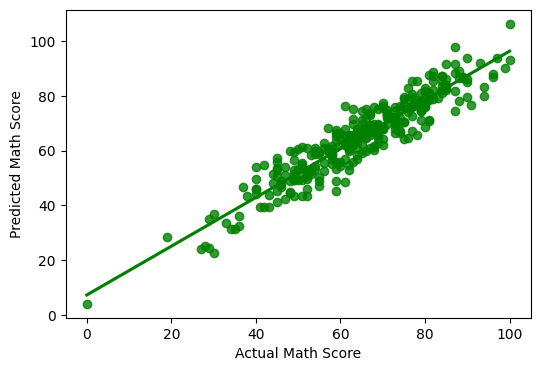

In [234]:
plt.figure(figsize=(6,4))
sns.regplot(x=y_test,y=y_pred,color='green',ci=None)
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.show()

In [239]:
model_params ={
    'Lasso':{
        'model': Lasso(),
        'params':{
            'alpha' : [0.1,1,10]
        }
    },
    
    'Ridge':{
        'model': Ridge(),
        'params': {
            'alpha' : [0.1,1,10]
        }
    },
    
    'svm':{
        'model': SVR(gamma='auto'),
        'params': {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }
    },

    'DecisionTree':{
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion' : ["squared_error", "absolute_error"]
        }
    },

    'RandomForest' : {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators' : [1,5,10]
        }
    },
}

In [240]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'], cv =5, return_train_score = False)
    clf.fit(X_train,y_train)
    scores.append(
        {
            'model':model_name,
            'best_score':clf.best_score_ * 100,
            'best_params':clf.best_params_
        }
    )

In [250]:
scores_df = pd.DataFrame(scores)
new_row = pd.DataFrame({'model': ['linear_regressor'], 'best_score':[score_lr], 'best_params':[np.nan]})
scores_df = pd.concat([scores_df,new_row],ignore_index=True)
scores_df

,model,best_score,best_params
0,Lasso,86.714398,{'alpha': 0.1}
1,Ridge,86.835825,{'alpha': 0.1}
2,svm,86.594822,"{'C': 10, 'kernel': 'linear'}"
3,DecisionTree,65.850021,{'criterion': 'squared_error'}
4,RandomForest,82.444395,{'n_estimators': 10}
5,linear_regressor,87.646618,NaN


Linear Regression with the highest score